# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'data/df_merch_3_mv_input.csv'


file_tag = "df_merch_outlier_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
test_data=True
# test_data=False

if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)
    

else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='returning_user'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)


sampled_data=data.sample(frac=0.01, replace=False)


data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7434 entries, 309 to 742469
Data columns (total 41 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_name                       7434 non-null   float64
 1   device_category                  7434 non-null   float64
 2   device_mobile_brand_name         7434 non-null   float64
 3   device_mobile_model_name         7434 non-null   float64
 4   device_operating_system          7434 non-null   float64
 5   device_operating_system_version  7434 non-null   float64
 6   device_language                  7434 non-null   float64
 7   device_web_info_browser          7434 non-null   float64
 8   device_web_info_browser_version  7434 non-null   float64
 9   geo_region                       7434 non-null   float64
 10  geo_city                         7434 non-null   float64
 11  traffic_source_medium            7434 non-null   float64
 12  traffic_source_source

# Outlier Analysis

- engagement_time_msec is the only numeric column that has outliers that need to be treated
- this is most likely due to idle time by the user when navigating in the page and then clicking on something after some minutes.

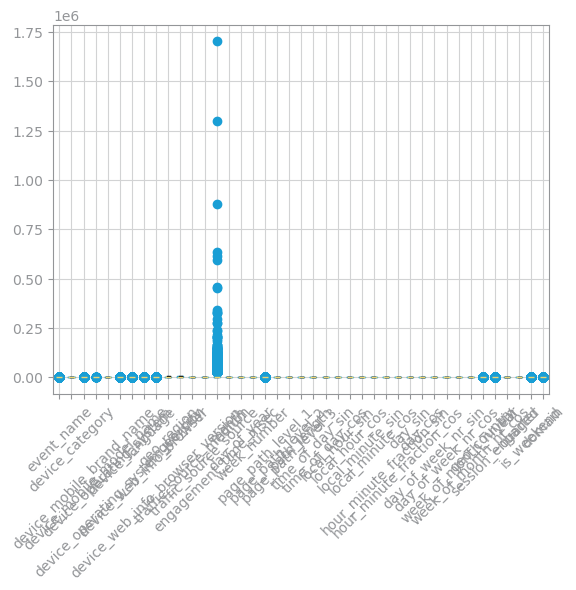

In [8]:
from matplotlib.pyplot import savefig, show


data.boxplot(rot=45)
# savefig(f"{file_tag}_global_boxplot.png")
show()


# Outlier 1 - Outlier Truncation

## Outlier strategy aplication

In [21]:
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)
# this script is available in data_functions originally from DSLabs site in Outlier chapter

data_1=data.copy()


top, bottom = determine_outlier_thresholds_for_var(data_1['engagement_time_msec'])
data_1['engagement_time_msec'] = data_1['engagement_time_msec'].apply(
    lambda x: top if x > top else bottom if x < bottom else x
)

# df.to_csv(f"data/{file_tag}_truncate_outliers.csv", index=True)
print("Data after truncating outliers:", data.shape)



data_1.describe()


KeyError: 'std'

## MV1 Target Prep

In [25]:
from numpy import array, ndarray

# labels: list = list(data_1[target].unique())
# labels.sort()
# print(f"Labels={labels}")

# positive: int = 1
# negative: int = 0
# values: dict[str, list[int]] = {
#     "Original": [
#         len(data_1[data_1[target] == negative]),
#         len(data_1[data_1[target] == positive]),
#     ]
# }

# y_1: array = data_1.pop(target).to_list()
# X_1: ndarray = data_1.values

y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


Labels=[0.0, 1.0]


## MV1 train/test split 

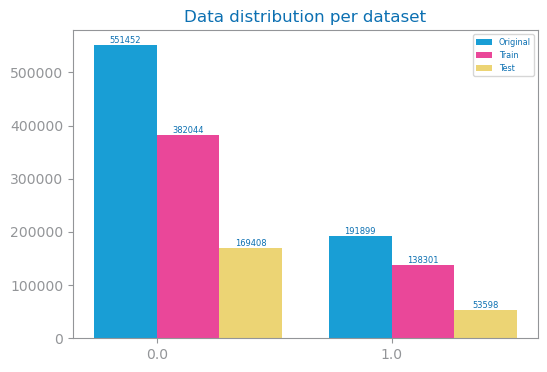

In [26]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## MV1 evaluate

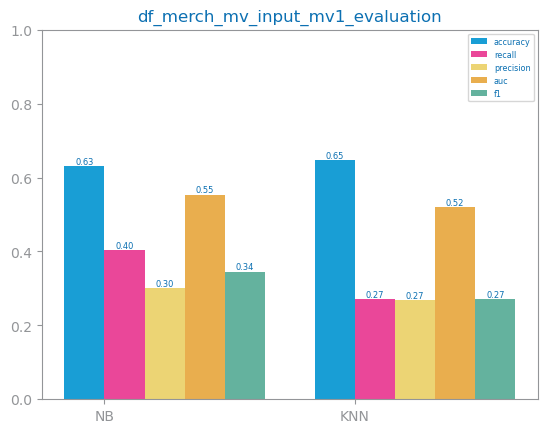

In [27]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='returning_user', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_mv1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_mv1_evaluation.png")
show()

# MV2 - drop null strategy

1. Remove 'device_language' due to high % of null values. Also, since we are not sure of its quality it makes more sense to remove it altogether without sacrificing the number of rows
2. Remove remaining null values records 

## MV2 strategy aplication

In [28]:
# numeric_vars: list[str] = get_variable_types(data)["numeric"]
data_2=data.copy()

data_2 = data_2.drop(['device_language','device_operating_system_version'], axis=1)
data_2 = data_2.dropna(axis=0, how="any")

## MV2 target prep

In [29]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)


Labels=[0, 1]


## MV2 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

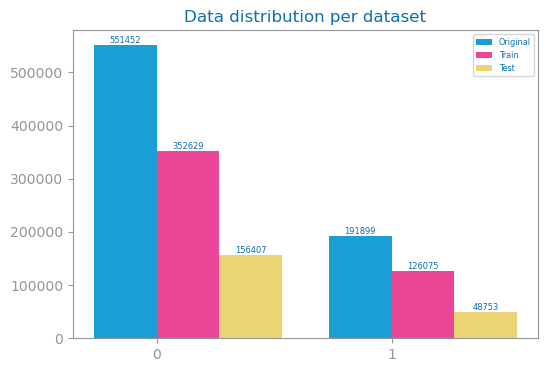

In [30]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## MV2 evaluate

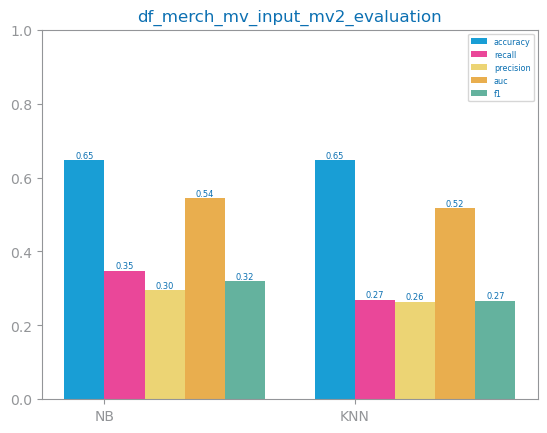

In [31]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='returning_user', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_mv2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_mv2_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [32]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   0.631279  0.403746  0.300936  0.553507  0.344841   0.647553   
KNN           0.647512  0.271559  0.268944  0.519008  0.270245   0.647777   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  0.347979  0.295120  0.544455  0.319377  0.016274 -0.055768   
KNN          0.269563  0.263933  0.517616  0.266718  0.000266 -0.001996   

                                           
            precision       auc        f1  
Naive Bayes -0.005815 -0.009051 -0.025464  
KNN         -0.005012 -0.001392 -0.003527

## t test

In [33]:

from scipy.stats import ttest_rel


# Perform paired t-tests for each metric
t_test_results = {'t_stat': [], 'p_value': []}
for metric in eval_1.keys():
    t_stat, p_value = ttest_rel(df_eval_1[metric], df_eval_2[metric])
    t_test_results['t_stat'].append(t_stat)
    t_test_results['p_value'].append(p_value)

# Create DataFrame for t-test results
df_ttest = pd.DataFrame(t_test_results, index=eval_1.keys())

# Convert t-test results to a DataFrame with MultiIndex and concatenate it
df_ttest_multi = pd.DataFrame({
    ('t_test', 't_stat'): df_ttest['t_stat'],
    ('t_test', 'p_value'): df_ttest['p_value']
})

df_ttest_multi

t_test          
              t_stat   p_value
accuracy   -1.033185  0.489610
recall      1.074230  0.477227
precision  13.470642  0.047173
auc         1.363489  0.402853
f1          1.321567  0.412378

# Analysis

- Uplift between missing value input approaches is significant when it comes to recall (40% to 35% drop on mv2). every other metric does not show significant uplifts
- there is low difference in terms of data processing (with frequent approach taking about 2 mins more with a 20% of the original dataset sample)
- we will move forward with approach 1 for missing values due to slightly better results on recall and more records dimensionality

# save to csv

In [35]:
if test_data==False:
    
    # train_2.to_csv(f"data/df_merch_3_mv_input_train.csv", index=False)
    # test_2.to_csv(f"data/df_merch_3_mv_input_test.csv", index=False)
    data_1.to_csv(f"data/df_merch_3_mv_input.csv", index=False)
    